<a href="https://colab.research.google.com/github/rohailkhan/Marketing_analytics/blob/main/5_Marketing_and_Research_Comparing_Groups_Tables_and_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
%config InlineBackend.figure_format = 'svg'
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 70)

## 5.1 Simulating consumer segment data

In [38]:
import pandas as pd
segment_data = pd.read_csv('http://bit.ly/PMR-ch5')
segment_data.head()

,Segment,age,gender,income,kids,own_home,subscribe
0,travelers,60.794945,male,57014.537526,0,True,False
1,travelers,61.764535,female,43796.941252,0,False,False
2,travelers,47.493356,male,51095.344683,0,True,False
3,travelers,60.963694,male,56457.722237,0,True,True
4,travelers,60.594199,female,103020.070798,0,True,False


In [39]:
segment_data.describe()

,age,income,kids
count,300.000000,300.000000,300.000000
mean,40.923350,50669.454237,1.273333
std,12.827494,19336.497748,1.413725
min,18.388730,11297.309231,0.000000
25%,32.870035,41075.804389,0.000000
50%,38.896711,51560.344807,1.000000
75%,47.987569,62172.668698,2.000000
max,79.650722,108830.388732,7.000000


### 5.1.1 Segment data definition

In [40]:
segment_variables = ['age', 'gender', 'income', 'kids', 'own_home',
                     'subscribe']
segment_variables_distribution = dict(zip(segment_variables,
                                          ['normal', 'binomial',
                                           'normal','poisson',
                                           'binomial', 'binomial']))

segment_variables_distribution['age']

'normal'

In [41]:
segment_variables_distribution

{'age': 'normal',
 'gender': 'binomial',
 'income': 'normal',
 'kids': 'poisson',
 'own_home': 'binomial',
 'subscribe': 'binomial'}

In [42]:
segment_means = {'suburb_mix': [40, 0.5, 55000, 2, 0.5, 0.1],
                 'urban_hip':  [24, 0.7, 21000, 1, 0.2, 0.2],
                 'travelers':  [58, 0.5, 64000, 0, 0.7, 0.05],
                 'moving_up':  [36, 0.3, 52000, 2, 0.3, 0.2]}

In [43]:
# standard deviations for each segment 
# None = not applicable for the variable)
segment_stddev = {'suburb_mix': [5, None, 12000, None, None, None],
                  'urban_hip':  [2, None, 5000, None, None, None],
                  'travelers':  [8, None, 21000, None, None, None],
                  'moving_up':  [4, None, 10000, None, None, None]}

Our next step is somewhat optional, but is good practice.

We now have nearly all we need to generate a simulated dataset.
But we can make our process cleaner by getting all values keyed by exactly what they are. What do we mean by that? We
used set the mean and standard deviation values in lists above, **but those are keyed numerically**, so if we changed the order
of our variables, we would use the wrong value. Instead, **it’s best practice to key them by the variable name**. So we will now
create a dictionary that contains all the statistics for each segment in a resilient structure from which we could create the
entire dataset without referencing any other variables.
There is one more statistic left to set, which is the segment sizes. Here, we set those, and then we iterate through all the
segments and all the variables and create a dictionary to hold everything:




In [44]:
segment_names = ['suburb_mix', 'urban_hip', 'travelers', 'moving_up']
segment_sizes = dict(zip(segment_names,[100, 50, 80, 70]))

segment_statistics = {}
for name in segment_names:
  segment_statistics[name] = {'size': segment_sizes[name]}
  for i, variable in enumerate(segment_variables):
    segment_statistics[name][variable] = {
        'mean': segment_means[name][i],
        'stddev': segment_stddev[name][i]
    }

In [45]:
segment_statistics['moving_up']

{'age': {'mean': 36, 'stddev': 4},
 'gender': {'mean': 0.3, 'stddev': None},
 'income': {'mean': 52000, 'stddev': 10000},
 'kids': {'mean': 2, 'stddev': None},
 'own_home': {'mean': 0.3, 'stddev': None},
 'size': 70,
 'subscribe': {'mean': 0.2, 'stddev': None}}

### 5.1.2 Final segment data generation

To outline how this will work, consider the following pseudocode (sentences organized like code):


```
# Set up dictionary "segment_constructor" and pseudorandom number sequence
For each SEGMENT i in "segment_names" {
Set up a temporary dictionary "segment_data_subset" for this SEGMENT’s data
For each VARIABLE in "seg_variables" {
Check "segment_variable_distribution[variable]" to find distribution type for VARIABLE
Look up the segment size and variable mean and standard deviation in segment_statistics for
that SEGMENT and VARIABLE to
... Draw random data for VARIABLE (within SEGMENT) with
... "size" observations
}
Add this SEGMENT’s data ("segment_data_subset") to the overall data ("segment_constructor")
Create a DataFrame "segment_data" from "segment_constructor"
}
```



In [46]:
import numpy as np
import pandas as pd

np.random.seed(seed=2554)
segment_constructor = {}

# Iterate over segments to create data for each
for name in segment_names:
  segment_data_subset = {}
  print('segment: {0}'.format(name))
  # Within each segment, iterate over the variables and generate data
  for variable in segment_variables:
    print('\tvariable: {0}'.format(variable))
    if segment_variables_distribution[variable] == 'normal':
      # Draw random normals
      segment_data_subset[variable] = np.random.normal(
          loc=segment_statistics[name][variable]['mean'],
          scale=segment_statistics[name][variable]['stddev'],
          size=segment_statistics[name]['size']
      )
    elif segment_variables_distribution[variable] == 'poisson':
      # Draw counts
      segment_data_subset[variable] = np.random.poisson(
          lam=segment_statistics[name][variable]['mean'],
          size=segment_statistics[name]['size']
      )
    elif segment_variables_distribution[variable] == 'binomial':
      # Draw binomials
      segment_data_subset[variable] = np.random.binomial(
          n=1,
          p=segment_statistics[name][variable]['mean'],
          size=segment_statistics[name]['size']
      )
    else:
      # Data type unknown
      print('Bad segment data type: {0}'.format(
          segment_variables_distribution[j])
           )
      raise StopIteration
  segment_data_subset['Segment'] = np.repeat(
      name,
      repeats=segment_statistics[name]['size']
  )
  segment_constructor[name] = pd.DataFrame(segment_data_subset)
segment_data = pd.concat(segment_constructor.values())

segment: suburb_mix
	variable: age
	variable: gender
	variable: income
	variable: kids
	variable: own_home
	variable: subscribe
segment: urban_hip
	variable: age
	variable: gender
	variable: income
	variable: kids
	variable: own_home
	variable: subscribe
segment: travelers
	variable: age
	variable: gender
	variable: income
	variable: kids
	variable: own_home
	variable: subscribe
segment: moving_up
	variable: age
	variable: gender
	variable: income
	variable: kids
	variable: own_home
	variable: subscribe


In [47]:
segment_data.head()

,age,gender,income,kids,own_home,subscribe,Segment
0,44.057078,0,54312.575694,3,0,0,suburb_mix
1,34.284213,0,67057.192182,1,0,0,suburb_mix
2,45.159484,0,56306.492991,3,1,0,suburb_mix
3,41.032557,1,66329.337521,1,0,1,suburb_mix
4,41.781819,0,56500.410372,2,0,0,suburb_mix


In [48]:
name = 'suburb_mix'
variable = 'age'
print(segment_statistics[name][variable]['mean'])
print(segment_statistics[name][variable]['stddev'])
np.random.normal(
    loc=segment_statistics[name][variable]['mean'],
    scale=segment_statistics[name][variable]['stddev'],
    size=10
)

40
5


array([37.16950666, 45.23743976, 44.23421807, 41.62070249, 30.66891058,
       44.86711234, 34.48936766, 42.63618686, 45.16799349, 42.61294136])

In [49]:
variable = 'kids'
print(segment_statistics[name][variable]['mean'])
print(segment_statistics[name][variable]['stddev'])
np.random.poisson(
    lam=segment_statistics[name][variable]['mean'],
    size=10
)

2
None


array([3, 2, 1, 3, 0, 1, 3, 3, 1, 3])

In [50]:
variable = 'gender'
print(segment_statistics[name][variable]['mean'])
print(segment_statistics[name][variable]['stddev'])
np.random.binomial(
    n=1,
    p=segment_statistics[name][variable]['mean'],
    size=10
)

0.5
None


array([1, 1, 0, 1, 1, 0, 0, 0, 0, 1])

In [51]:
np.repeat(name, repeats=10)

array(['suburb_mix', 'suburb_mix', 'suburb_mix', 'suburb_mix',
       'suburb_mix', 'suburb_mix', 'suburb_mix', 'suburb_mix',
       'suburb_mix', 'suburb_mix'], dtype='<U10')

To finish up the dataset, we perform a few housekeeping tasks, converting each binomial variable to clearer values,
booleans or strings:

In [52]:
segment_data['gender'] = segment_data['gender'].apply(
    lambda x: 'male' if x else 'female'
)
segment_data['own_home'] = segment_data['own_home'].apply(
    lambda x: True if x else False
)
segment_data['subscribe'] = segment_data['subscribe'].apply(
    lambda x: True if x else False
)

In [53]:
segment_data.describe(include='all')

,age,gender,income,kids,own_home,subscribe,Segment
count,300.000000,300,300.000000,300.000000,300,300,300
unique,NaN,2,NaN,NaN,2,2,4
top,NaN,male,NaN,NaN,False,False,suburb_mix
freq,NaN,156,NaN,NaN,167,265,100
mean,40.923350,NaN,50669.454237,1.273333,NaN,NaN,NaN
std,12.827494,NaN,19336.497748,1.413725,NaN,NaN,NaN
min,18.388730,NaN,11297.309231,0.000000,NaN,NaN,NaN
25%,32.870035,NaN,41075.804389,0.000000,NaN,NaN,NaN
50%,38.896711,NaN,51560.344807,1.000000,NaN,NaN,NaN
75%,47.987569,NaN,62172.668698,2.000000,NaN,NaN,NaN


In [54]:
segment_data.head()

,age,gender,income,kids,own_home,subscribe,Segment
0,44.057078,female,54312.575694,3,False,False,suburb_mix
1,34.284213,female,67057.192182,1,False,False,suburb_mix
2,45.159484,female,56306.492991,3,True,False,suburb_mix
3,41.032557,male,66329.337521,1,False,True,suburb_mix
4,41.781819,female,56500.410372,2,False,False,suburb_mix


Saving as csv

In [55]:
from google.colab import files
with open('segment_dataframe_Python_intro_Ch5.csv', 'w') as f:
  segment_data.to_csv(f)

files.download('segment_dataframe_Python_intro_Ch5.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5.2 Finding descriptives by group

**1-Find the mean income for the “moving_up” segment:**

In [56]:
segment_data.head(3)

,age,gender,income,kids,own_home,subscribe,Segment
0,44.057078,female,54312.575694,3,False,False,suburb_mix
1,34.284213,female,67057.192182,1,False,False,suburb_mix
2,45.159484,female,56306.492991,3,True,False,suburb_mix


In [57]:
segment_data.loc[segment_data.Segment == 'moving_up']['income'].mean()

51763.55266630598

**1-Find the mean income for alll segment:**

In [58]:
segment_data.groupby('Segment')[['income']].mean()

,income
Segment,
moving_up,51763.552666
suburb_mix,55552.282925
travelers,62609.655328
urban_hip,20267.737317


In [59]:
segment_data.loc[
    (segment_data['Segment'] == 'moving_up') &
    (segment_data['subscribe'] == False)
]['income'].mean()

52495.682083903506

In [60]:
segment_data.groupby('Segment')['income'].mean()

Segment
moving_up     51763.552666
suburb_mix    55552.282925
travelers     62609.655328
urban_hip     20267.737317
Name: income, dtype: float64

In [61]:
segment_data.groupby(['Segment', 'subscribe'])['income'].mean()

Segment     subscribe
moving_up   False        52495.682084
            True         49079.078135
suburb_mix  False        55332.038973
            True         58478.381142
travelers   False        62940.429960
            True         49709.444658
urban_hip   False        20496.375001
            True         19457.112800
Name: income, dtype: float64

Using unstack

In [86]:
segment_data.groupby(
    ['Segment', 'subscribe']
)['income'].mean().unstack()

subscribe,False,True
Segment,,
moving_up,52495.682084,49079.078135
suburb_mix,55332.038973,58478.381142
travelers,62940.429960,49709.444658
urban_hip,20496.375001,19457.112800


In [87]:
segment_data.head(2)

,age,gender,income,kids,own_home,subscribe,Segment
0,44.057078,female,54312.575694,3,False,False,suburb_mix
1,34.284213,female,67057.192182,1,False,False,suburb_mix


**2 Get the segment mean income values, and then using join() to add the mean segment income as a column income_seg.**

In [92]:
segment_income=segment_data.groupby('Segment')[['income']].mean()
segment_data.join(segment_income , on='Segment', rsuffix='_seg').head(3)

,age,gender,income,kids,own_home,subscribe,Segment,income_seg
0,44.057078,female,54312.575694,3,False,False,suburb_mix,55552.282925
1,34.284213,female,67057.192182,1,False,False,suburb_mix,55552.282925
2,45.159484,female,56306.492991,3,True,False,suburb_mix,55552.282925


In [63]:
np.random.seed(4532)
segment_income = segment_data.groupby('Segment')['income'].mean()
segment_data = segment_data.join(segment_income,
                                 on='Segment',
                                 rsuffix='_segment')
segment_data.head(5)

,age,gender,income,kids,own_home,subscribe,Segment,income_segment
0,44.057078,female,54312.575694,3,False,False,suburb_mix,55552.282925
1,34.284213,female,67057.192182,1,False,False,suburb_mix,55552.282925
2,45.159484,female,56306.492991,3,True,False,suburb_mix,55552.282925
3,41.032557,male,66329.337521,1,False,True,suburb_mix,55552.282925
4,41.781819,female,56500.410372,2,False,False,suburb_mix,55552.282925


In [64]:
segment_data.drop(labels='income_segment', axis=1, inplace=True)
segment_data.head(5)

,age,gender,income,kids,own_home,subscribe,Segment
0,44.057078,female,54312.575694,3,False,False,suburb_mix
1,34.284213,female,67057.192182,1,False,False,suburb_mix
2,45.159484,female,56306.492991,3,True,False,suburb_mix
3,41.032557,male,66329.337521,1,False,True,suburb_mix
4,41.781819,female,56500.410372,2,False,False,suburb_mix


### 5.2.1 Descriptives for two-way groups

In [65]:
segment_data.groupby(['Segment', 'own_home'])['income'].mean()

Segment     own_home
moving_up   False       51430.222115
            True        52363.547659
suburb_mix  False       56764.508540
            True        54239.038508
travelers   False       62923.233941
            True        62449.907732
urban_hip   False       20139.092369
            True        21057.984851
Name: income, dtype: float64

In [66]:
segment_data.groupby(
    ['Segment', 'own_home', 'subscribe']
)['income'].mean()

Segment     own_home  subscribe
moving_up   False     False        52380.092911
                      True         47630.738931
            True      False        52714.693149
                      True         51251.586942
suburb_mix  False     False        56478.645027
                      True         59451.625569
            True      False        54160.506701
                      True         56045.270075
travelers   False     False        62923.233941
            True      False        62949.533735
                      True         49709.444658
urban_hip   False     False        20171.798013
                      True         20031.163747
            True      False        22281.548438
                      True         13716.603325
Name: income, dtype: float64

In [67]:
segment_data.groupby(
    ['Segment', 'own_home', 'subscribe']
)['income'].mean().unstack()

subscribe                   False         True 
Segment    own_home                            
moving_up  False     52380.092911  47630.738931
           True      52714.693149  51251.586942
suburb_mix False     56478.645027  59451.625569
           True      54160.506701  56045.270075
travelers  False     62923.233941           NaN
           True      62949.533735  49709.444658
urban_hip  False     20171.798013  20031.163747
           True      22281.548438  13716.603325

In [68]:
segment_data.groupby(
    ['Segment', 'own_home']
)['subscribe'].count().unstack()

own_home,False,True
Segment,,
moving_up,45,25
suburb_mix,52,48
travelers,27,53
urban_hip,43,7


In [69]:
segment_data.groupby(
    ['kids', 'Segment']
).subscribe.count().unstack(level=1)

Segment,moving_up,suburb_mix,travelers,urban_hip
kids,,,,
0,13.0,15.0,80.0,14.0
1,18.0,27.0,NaN,21.0
2,21.0,21.0,NaN,12.0
3,9.0,29.0,NaN,1.0
4,5.0,3.0,NaN,1.0
5,2.0,3.0,NaN,1.0
6,1.0,2.0,NaN,NaN
7,1.0,NaN,NaN,NaN


## Cross tab same as groupby plus unstack

In [70]:
pd.crosstab(segment_data['kids'], segment_data['Segment'])

Segment,moving_up,suburb_mix,travelers,urban_hip
kids,,,,
0,13,15,80,14
1,18,27,0,21
2,21,21,0,12
3,9,29,0,1
4,5,3,0,1
5,2,3,0,1
6,1,2,0,0
7,1,0,0,0


In [71]:
segment_data.groupby('Segment')['kids'].sum()

Segment
moving_up     130
suburb_mix    195
travelers       0
urban_hip      57
Name: kids, dtype: int64

### 5.2.2 Visualization by group: frequencies and proportions

Text(0.5, 0, 'counts')

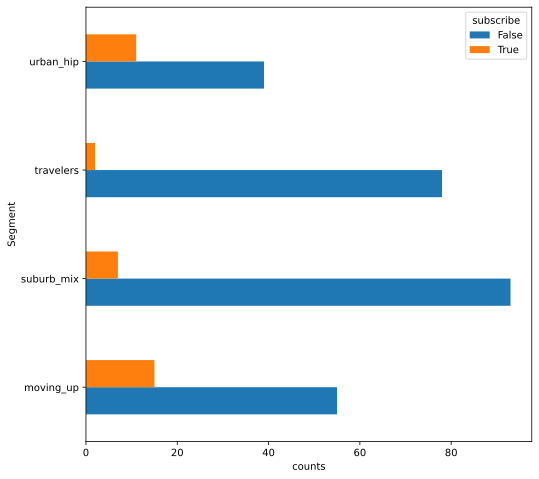

In [72]:
import matplotlib.pyplot as plt

segments_groupby_segments = segment_data.groupby(['Segment']) 
segments_groupby_segments['subscribe'].value_counts().unstack().plot(
    kind='barh',
    figsize=(8, 8)
)
plt.xlabel('counts')

Text(0.5, 0, 'proportion of segment')

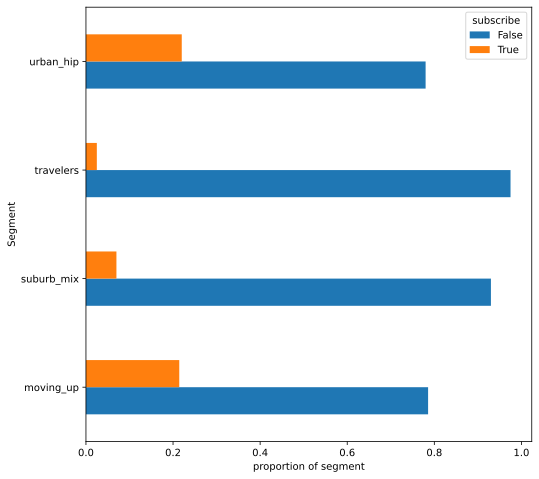

In [73]:
segments_groupby_segments['subscribe'].value_counts(
    normalize=True
).unstack().plot(
    kind='barh',
    figsize=(8, 8)
)
plt.xlabel('proportion of segment')

Text(0.5, 0, 'proportion of subscribers')

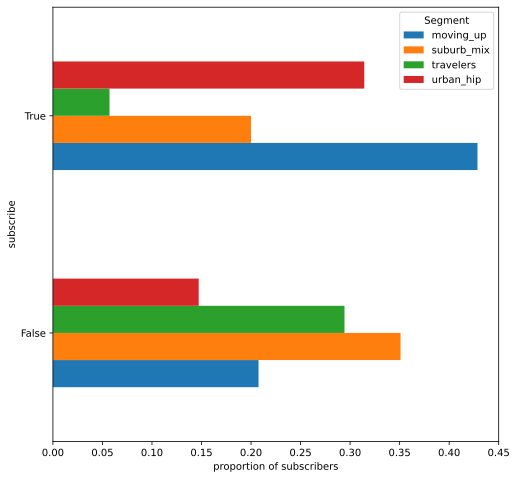

In [74]:
segment_data.groupby(['subscribe'])['Segment'].value_counts(
    normalize=True
).unstack().plot(kind='barh', figsize=(8, 8))
plt.xlabel('proportion of subscribers')

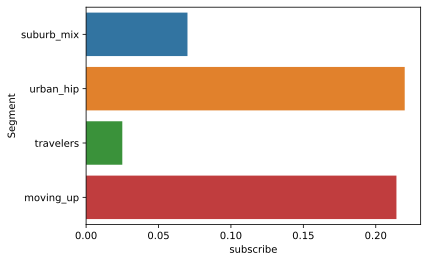

In [97]:
import seaborn as sns
sns.barplot(y='Segment', x='subscribe', data=segment_data,
            orient='h', ci=None)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


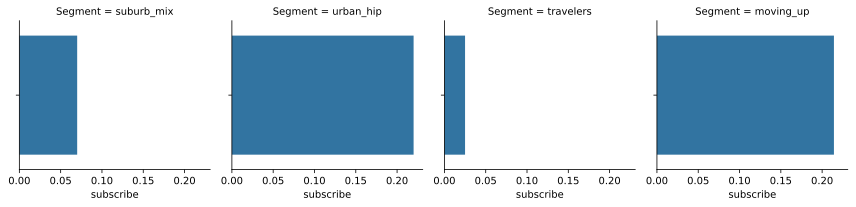

In [99]:
g = sns.FacetGrid(segment_data, col='Segment')
g.map(sns.barplot, 'subscribe', orient='v', ci=None)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.7/dist-packages/seaborn/_

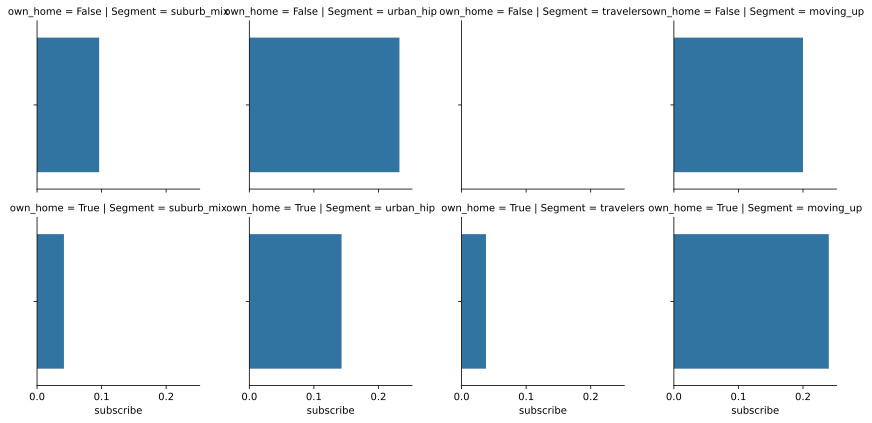

In [77]:
g = sns.FacetGrid(segment_data, col='Segment', row='own_home')
g.map(sns.barplot, 'subscribe', orient='v', ci=None)

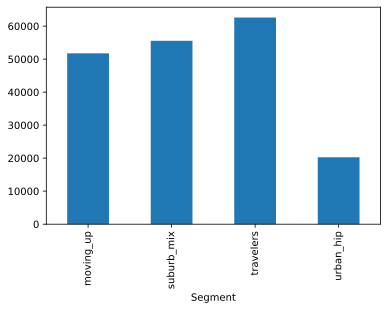

In [78]:
segment_data.groupby(['Segment'])['income'].mean().plot.bar()

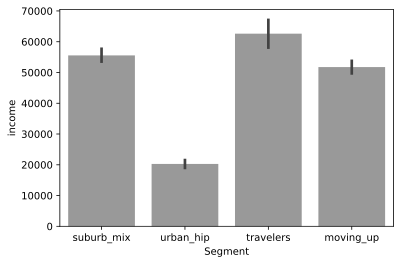

In [79]:
sns.barplot(x='Segment', y='income', data=segment_data, color='.6', 
            estimator=np.mean, ci=95)

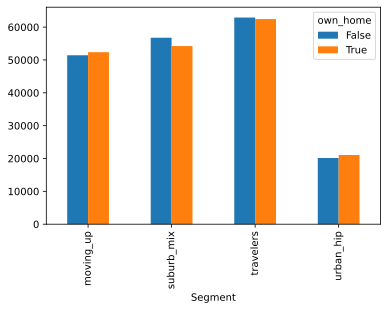

In [80]:
segment_data.groupby(
    ['Segment', 'own_home']
)['income'].mean().unstack().plot.bar()

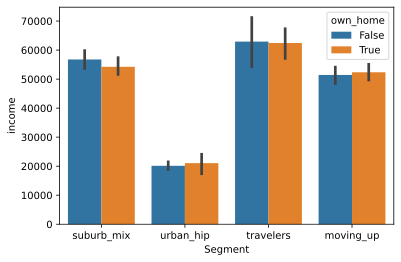

In [81]:
sns.barplot(x='Segment', y='income', hue='own_home',
            data=segment_data, estimator=np.mean, ci=95)

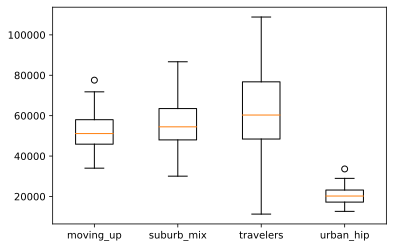

In [82]:
x = segment_data.groupby('Segment')['income'].apply(list)
_ = plt.boxplot(x=x.values, labels=x.index)

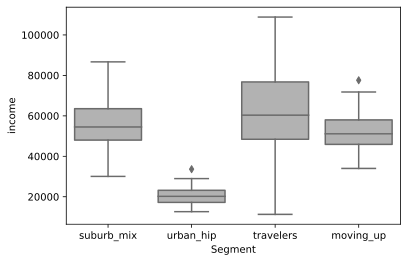

In [83]:
sns.boxplot(x='Segment', y='income', data=segment_data,
            color='0.7', orient='v')

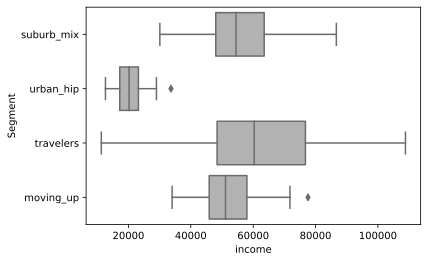

In [84]:
sns.boxplot(y='Segment', x='income', data=segment_data, 
            color='0.7', orient='h')

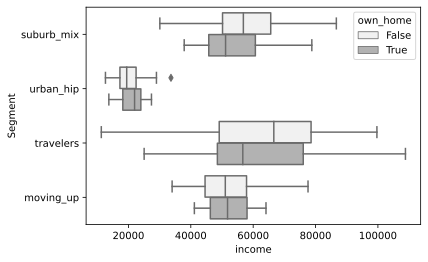

In [85]:
sns.boxplot(y='Segment', x='income', hue='own_home',
            data=segment_data, color='0.7', orient='h')